# Practical 3: Kernel methods and decision trees

Note: Please use sklearn or other ML libraries only where explicitly asked to do so.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt  # needed later on for SVM

In [2]:
#conda install -c conda-forge cvxopt

# Task 0: Preliminaries

This time we will work with a synthetic 2d dataset to facilitate visualization and be able to focus on the algorithms rather than spending energy to understand the dataset. The dataset consists of two classes and two predictors. Below we load the dataset and plot it.

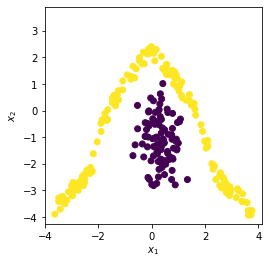

In [3]:
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:,:2], np.load('nonlin_2d_data.npy')[:, 2]

plt.scatter(X_2d[:,0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square');

#### Task 0.1

Apply logistic regression to the provided data and investigate how it performs. You're welcome to use sklearn for this task.

In [4]:
# from Practical 2
def split_data(X, y, frac=0.3, max_samples=None, seed=4711):

    if seed is not None:
        np.random.seed(seed)

    indices = np.random.permutation(len(X))
    indices = indices[:max_samples]
    indices_test, indices_train = indices[:int(len(indices)*frac)], indices[int(len(indices)*frac):]

    assert (len(set(indices))) == len(indices)
    assert len(set(indices_test).intersection(indices_train)) == 0
    
    X_train, X_test = X[indices_train], X[indices_test]
    y_train, y_test = y[indices_train], y[indices_test]
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train,X_test,y_train,y_test=split_data(X_2d,t_2d)
X_train.shape

(175, 2)

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
clf = LogisticRegression().fit(X_train, y_train)
clf.score(X_test, y_test)

0.6533333333333333

# Task 1: Kernel Discriminant Analysis

We will be implementing Kernel Discriminant Analysis, a nonlinear extension to LDA based on the kernel trick, following the original paper by Mika, Rätsch, Weston, Schölkopf and Müller (PDF on StudIP).

The goal of Kernel Discriminant Analysis is find a vector of $\alpha$'s that maximizes
$$ J(\alpha) = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} $$
where 
$$(M_i)_j = \frac{1}{l_i} \sum_{k=1}^{l_i} k(x_j, x_k^i)$$ and
$$N= \sum_{j=1,2} K_j (I - 1_{l_j}) K_j^T$$
Here, the number of samples for class $j$ is denoted by $l_j$. In the definition of $N$, $(K_{j})_{n,m} = k(x_n, x_m^j)$, $I$ is the identity matrix and $1_{l_j}$ is a matrix with each entry equal to $1/l_j$. $M$ has shape $2 \times (l_0 + l_1)$, $N$ has shape $(l_0 + l_1) \times (l_0 + l_1)$.

We obtain the optimal solution by $\alpha = N^{-1}(M_1 - M_0)$. Note that you may have to regularize $N^{-1}$ for numerical stability (see paper or Wikipedia).

1. Implement a function `kda(X, t, kernel)` that carries out Kernel Discriminant Analysis on the data $X,t$ and returns a vector `alpha`.
2. Implement a function `def predict(alpha, x)`
3. Visualize results given a linear kernel and a radial basis function kernel.

Use the following snippet as a starting point.

In [8]:
 X_train, X_test, y_train, y_test = split_data(X_2d, t_2d, 0.3,None,4711)

In [9]:
def linear_kernel(x_n, x_m):
    return x_n.dot(x_m)

def rbf_kernel(x_n, x_m, gamma=5, **kwargs):
    return np.exp(-np.power(x_n - x_m, 2).sum()/gamma)

In [10]:
def kernel_transform(X,kernel):
    if kernel == 'Linear':
        kfunc = linear_kernel
        
    elif kernel == 'rbf':
        kfunc = rbf_kernel
    
    
    n_samples, n_features = X.shape
    n_samples = n_samples
    n_features = n_features
    
    K = np.zeros((n_samples,n_samples))
    
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = kfunc(X[i],X[j])
            
    return K   

In [11]:
K_mat_rbf= kernel_transform(X_train,'rbf')
np.shape(K_mat_rbf)

(175, 175)

In [12]:
K_mat_linear= kernel_transform(X_train,'Linear')
np.shape(K_mat_linear)

(175, 175)

In [13]:
# Calculate alpha
def calculate_alpha(X,t,K_mat):

    X_split = X[(t==0)], X[(t==1)]

    n = X.shape[0]

    idx1 = np.where(t == 1)[0]
    idx2 = np.where(t == 0)[0]

    n1 = idx1.shape[0]
    n2 = idx2.shape[0]
   
    K1, K2 = K_mat[:,idx1], K_mat[:,idx2]
    
   # print(K1)

    N1 = np.dot(np.dot(K1, np.eye(n1)-(1/float(n1))),K1.T)
    N2 = np.dot(np.dot(K2, np.eye(n2)-(1/float(n2))),K2.T)
    
    #print(N2)

    #Calculate N 

    N = N1 + N2+np.diag(np.repeat(0.001,n))
    Ni = np.linalg.inv(N)

    m1 = np.sum(K1,axis = 1)/ float(n1)
    m2 = np.sum(K2,axis = 1)/ float(n2)
    d = m2-m1
    
    #print(np.shape(d))

    # Calculate M
    M = np.dot(d.reshape(-1,1),d.reshape(1,-1))
   
    #alpha

    alpha = np.linalg.solve(Ni,d)
   # alpha2 = np.dot(Ni,d)
    #print(alpha)
    #print(alpha2)

    #b = np.dot(alpha,(n1*m1 +n2*m2)/float(n))
    
    return alpha

In [14]:
alpha_rbf = calculate_alpha(X_train,y_train,K_mat_rbf)
print(np.shape(alpha_rbf))
alpha_rbf

(175,)


array([  40.06921496,  136.64145944,  148.4831706 , -104.84808826,
        126.67694906,   79.36537899,  172.39257821,   88.89704829,
         86.41264834,   69.25967958,  157.06906921,  -61.82240371,
       -103.161264  ,  138.85529226,  169.20551294,   55.02855021,
        149.22252321,  -91.55382512,  137.22893647,   37.44030808,
         65.27793157,  150.9672669 ,   86.45345889,   66.15340974,
         59.68644679,  -61.80214886,  156.80167118, -102.94384095,
        -71.34687205,   79.93702219,  144.58608321,  -59.43999162,
         34.46060881,   72.05810731,  141.70017697,  143.99466914,
         80.8112086 ,   20.47489358,   61.89470696,  -65.85891169,
        155.26506898, -102.72674137,   14.35611808, -102.79340412,
        139.48833512,  115.83341167,  -93.5094257 ,  133.91356303,
        -64.07966446,   30.84726751,  151.56547689,  -98.99878881,
        115.19396366,  129.53957699, -102.03319191,  162.06780868,
         55.59045194,  108.22887911, -100.13927201,  139.61822

In [15]:
alpha_linear = calculate_alpha(X_train,y_train,K_mat_linear)
print(np.shape(alpha_linear))
alpha_linear

(175,)


array([-75055.05706403,  56143.48163674,  52694.00221662,  39652.51024092,
        52697.5680241 , -42847.59896947,  43701.94324372,  86672.12286028,
        57170.51995855,  44395.92331817,  69606.13006273, 187877.79438153,
        28868.50118013,  79278.8497274 ,  46152.39651851, -49817.73527571,
        80658.79179   ,  29293.68276353,  56909.69197346,  90210.12989282,
       -70574.4239759 ,  17483.97341849, -50622.88308292, -64837.75595356,
       102867.37377186,  26128.05870221,  41457.83781956, 237752.88517059,
        22159.84413922,  90291.44595485,  57947.09496102,  18373.79325589,
       141714.40960037,  89951.78244623,   -879.47097924,  13391.28444974,
       -31788.88345459, -81064.59002297, -47989.39821807, 190372.45324291,
        32529.95900863, 240249.50893015, -89917.99230264,  33691.86807491,
        -1085.80622649,  83638.60205795,  27040.17921922,  -6229.46900512,
       189264.96960757, 107349.77871075,  51649.83489348, 225468.776928  ,
        66208.85113376,  

In [35]:
def predict(alpha,x):
        
    Y = []
    temp = 0
    for i in range(len(x)):
        temp += alpha[i]*rbf_kernel(x[i],x)
        Y.append(temp)
    Y = np.array(Y)
    
    return Y

In [36]:
Y_predict_rbf = predict(alpha_rbf,X_train)
np.shape(Y_predict_rbf)
#Y_predict_rbf

(175,)

Text(0.5, 1.0, 'RBF kernel Predict')

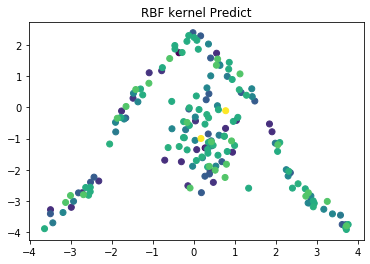

In [37]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_predict_rbf)
plt.title('RBF kernel Predict')

In [30]:
def predict(alpha,x):
        
    Y = []
    temp = 0
    for i in range(len(x)):
        temp += alpha[i]*linear_kernel(x[i],x[i])
        Y.append(temp)
    Y = np.array(Y)
    
    return Y

In [31]:
Y_predict_linear = predict(alpha_rbf,X_train)
np.shape(Y_predict_linear)
#Y_predict_linear

(175,)

Text(0.5, 1.0, 'Linear kernel Predict')

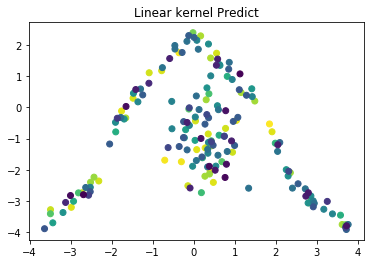

In [43]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_predict_linear)
plt.title('Linear kernel Predict')

For Test Dataset:

In [45]:
K_mat_rbf_test= kernel_transform(X_test,'rbf')
np.shape(K_mat_rbf_test)

(75, 75)

In [55]:
alpha_rbf_test = calculate_alpha(X_test,y_test,K_mat_rbf_test)
print(np.shape(alpha_rbf_test))
#alpha_rbf

(75,)


In [62]:
Y_predict_rbf_test = predict(alpha_rbf_test,X_test)
np.shape(Y_predict_rbf_test)
min(Y_predict_rbf_test)
max(Y_predict_rbf_test)

1.040877738136734e-39

In [65]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [66]:
Average(Y_predict_rbf_test)

3.9868968144329766e-40

Text(0.5, 1.0, 'RBF kernel Predict')

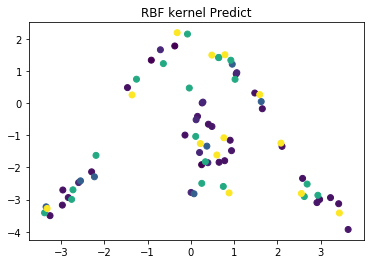

In [52]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_predict_rbf_test)
plt.title('RBF kernel Predict For Test data')

In [53]:
K_mat_linear_test= kernel_transform(X_test,'Linear')
np.shape(K_mat_linear_test)

alpha_linear_test = calculate_alpha(X_test,y_test,K_mat_linear_test)
print(np.shape(alpha_linear_test))
#alpha_rbf

Y_predict_linear_test = predict(alpha_linear_test,X_test)
np.shape(Y_predict_linear_test)
#Y_predict_rbf


(75,)


(75,)

Text(0.5, 1.0, 'Linear kernel Predict For Test data')

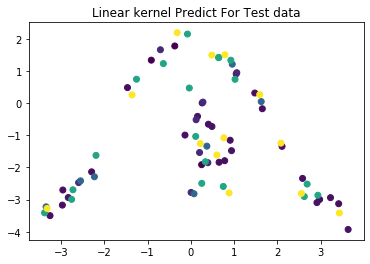

In [54]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_predict_linear_test)
plt.title('Linear kernel Predict For Test data')

In [84]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,Y_predict_rbf_test.astype(int)))


0.3466666666666667


In [81]:
print(metrics.accuracy_score(y_train,Y_predict_rbf.astype(int)))

0.4228571428571429


#### Task 1.2

Which value would you use as a threshold to separate the classes? Use this threshold value to visualize the decision boundaries in a 2d grid (see example code below) and make predictions on the test set.

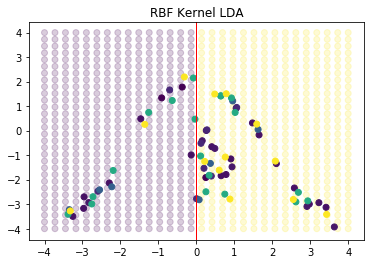

In [87]:
threshold = Average(Y_predict_rbf_test)

Y_predict_rbf_test_normalized = []

for i in range(0,len(Y_predict_rbf_test)):
    if Y_predict_rbf_test[i]<threshold:
        Y_predict_rbf_test_normalized.append(0)
    else:
        Y_predict_rbf_test_normalized.append(1)



def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.
    
    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([x, y]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)

# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: x[0] > threshold 
plot_decision_boundary(predict_fn)

 
plt.title('RBF Kernel LDA')
plt.scatter( X_test[:,0], X_test[:,1], c=Y_predict_rbf_test)
plt.axvline(threshold, color='r', linewidth=1)
#plot_decision_boundary(Y_predict_rbf_test)
plt.show()


# Task 2: Support Vector Machines

Next, you will implement a Support Vector Machine (SVM). For solving the quadratic program, we provide a simple interface to the cvxopt library below.

In SVMs, each data sample $x_n$ has a corresponding parameter $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha - \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ and $h$ are vectors with one element per individual constraint.


#### Task 2.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver.

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.

In [26]:
import numpy as np
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from numpy import linalg
#import cvxopt 
#import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
    #def __init__(self, kernel=gaussian_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))


       # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)



        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
  
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

#### Task 2.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function to compute the accuracy of a linear SVM on the test set.

In [27]:
def test_linear():
    
    X_train, X_test, y_train, y_test = split_data(X_2d, t_2d, 0.3,None,4711)
    lm = SVM(C=100)
    lm.fit(X_train, y_train)

    y_predict = lm.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))
    accuracy = accuracy_score(y_test,y_predict)*100
    print("Accuracy: %f" % accuracy)
    #print('score linear kernel', np.mean(y_predict == y_test))

In [28]:
from sklearn.metrics import accuracy_score

cvxopt.solvers.options['show_progress'] = True   
test_linear()

     pcost       dcost       gap    pres   dres
 0: -3.7370e+03 -3.9120e+05  4e+05  1e-02  3e-14
 1: -3.8067e+03 -1.1331e+04  8e+03  3e-04  1e-14
 2: -6.6487e+03 -7.5233e+03  9e+02  3e-05  2e-14
 3: -7.3925e+03 -7.4022e+03  1e+01  3e-07  2e-14
 4: -7.3999e+03 -7.4000e+03  1e-01  3e-09  1e-14
 5: -7.4000e+03 -7.4000e+03  1e-03  3e-11  2e-14
Optimal solution found.
74 support vectors out of 175 points
26 out of 75 predictions correct
Accuracy: 34.666667


**Task 2.3**

- Instead of using the linear kernel (dot product), implement a Gaussian RBF kernel and use it in your SVM.
- Compare results with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary.

In [29]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

'''def linear_kernel(x1, x2):
    return np.dot(x1, x2)'''

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

     pcost       dcost       gap    pres   dres
 0: -7.4000e+01 -1.4800e+02  4e+02  1e+01  2e+00
 1: -3.3217e+02 -3.3549e+02  1e+02  7e+00  1e+00
 2: -3.7318e+04 -3.7322e+04  1e+02  7e+00  1e+00
 3: -3.6989e+08 -3.6989e+08  5e+02  7e+00  1e+00
 4: -3.6619e+14 -3.6619e+14  4e+06  7e+00  1e+00
 5: -3.6253e+22 -3.6253e+22  4e+12  5e+05  1e+00
 6: -3.5890e+32 -3.5890e+32  4e+20  6e+15  1e+00
 7: -3.5530e+44 -3.5530e+44  4e+30  5e+00  1e+00
 8: -3.5076e+58 -3.5076e+58  4e+42  7e+41  1e+00
 9: -3.4726e+90 -3.4726e+90  3e+74  5e-02  7e-01
10: -3.4378e+122 -3.4378e+122  3e+106  5e-04  7e-01
11: -3.4035e+154 -3.4035e+154  3e+138 8e+137  7e-01
12: -3.3694e+186 -3.3694e+186  3e+170  5e-08  7e-01
13: -3.3694e+186 -3.3694e+186  3e+170  5e-08  7e-01
14: -3.3694e+186 -3.3694e+186  3e+170  5e-08  7e-01
15: -3.3694e+186 -3.3694e+186  3e+170  5e-08  7e-01
16: -3.3694e+186 -3.3694e+186  3e+170  5e-08  8e-01
17: -3.3694e+186 -3.3694e+186  3e+170  5e-08  1e+00
18: -3.3694e+186 -3.3694e+186  3e+170  5e-08  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: No contour levels were found within the data range.
  


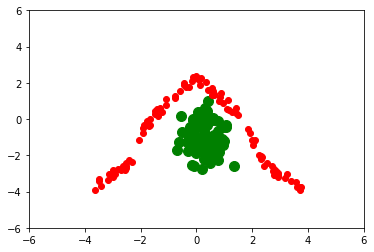

In [30]:
if __name__ == "__main__":
    import matplotlib.pyplot as pl
    
    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        pl.axis("tight")
        pl.show()
    
              
    def test_non_linear():
        X_train, X_test, y_train, y_test = split_data(X_2d, t_2d, 0.3,None,4711)
        
        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        accuracy = accuracy_score(y_test,y_predict)*100
        print(accuracy)
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

     

    cvxopt.solvers.options['show_progress'] = True  
    test_non_linear()
    

The Linear Kernel has 70-75 Support Vectors (red), leading to an accuracy of only 60%

In [31]:
#Linear 
from sklearn import svm

X_train, X_test, y_train, y_test = split_data(X_2d, t_2d, seed=1)
clf_g = svm.SVC(kernel = 'linear')
clf_g.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
y_pred_g = clf_g.predict(X_test)

In [33]:
accuracy = accuracy_score(y_test,y_pred_g)*100
accuracy

60.0

In [34]:
clf_g.support_vectors_
# get indices of support vectors
clf_g.support_
# get number of support vectors for each class
clf_g.n_support_

array([70, 75], dtype=int32)

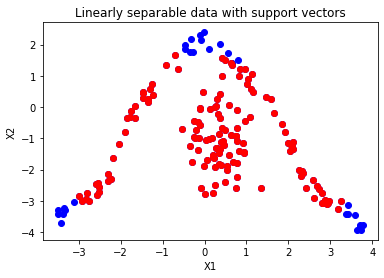

In [35]:
support_vectors_g = clf_g.support_vectors_

# Visualize support vectors
plt.scatter(X_train[:,0], X_train[:,1], color = 'blue')
plt.scatter(support_vectors_g[:,0], support_vectors_g[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

The Gaussian Kernel has 16-17 Support Vectors (red), leading to an accuracy of only 100%

In [36]:
from sklearn import svm
#Gaussian
X_train, X_test, y_train, y_test = split_data(X_2d, t_2d, seed=1)
clf = svm.SVC(kernel = 'rbf')
#clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
clf.support_vectors_
# get indices of support vectors
clf.support_
# get number of support vectors for each class
clf.n_support_

array([16, 17], dtype=int32)

In [39]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)*100
accuracy

100.0

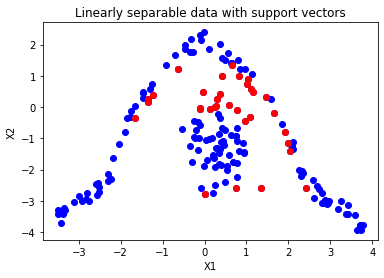

In [40]:
# Get support vectors themselves
support_vectors = clf.support_vectors_

# Visualize support vectors
plt.scatter(X_train[:,0], X_train[:,1], color = 'blue')
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Task 3: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the removed impurity can be computed by $l - l_a + l_b$

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


#### Task 3.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples.

In [41]:
# Load Wine dataset and split into train+test set
from sklearn.datasets import load_wine
X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X, t)

In [42]:
X_new=X[:,0:12]
X_new

array([[14.23,  1.71,  2.43, ...,  5.64,  1.04,  3.92],
       [13.2 ,  1.78,  2.14, ...,  4.38,  1.05,  3.4 ],
       [13.16,  2.36,  2.67, ...,  5.68,  1.03,  3.17],
       ...,
       [13.27,  4.28,  2.26, ..., 10.2 ,  0.59,  1.56],
       [13.17,  2.59,  2.37, ...,  9.3 ,  0.6 ,  1.62],
       [14.13,  4.1 ,  2.74, ...,  9.2 ,  0.61,  1.6 ]])

In [43]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [44]:
raw_data = load_wine()
features = pd.DataFrame(data=raw_data['data'],columns=raw_data['feature_names'])
data = features
data['target']=raw_data['target']
data['class']=data['target'].map(lambda ind: raw_data['target_names'][ind])
data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2,class_2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2,class_2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2,class_2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2,class_2


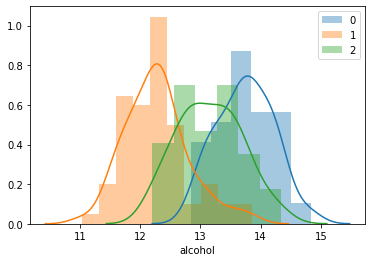

In [45]:
#1. Plot the distribution of the first feature of for each class of the wine dataset.

for i in data.target.unique():
    sns.distplot(data['alcohol'][data.target==i],kde=1,label='{}'.format(i))

plt.legend()

In [46]:
#2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
def gini_impurity(t):
    unique_values=np.unique(t)
    t_list=[]
    for i in range(0,len(unique_values)):
        t_list.append(list(t.flatten()).count(unique_values[i]))
    summe=0
    for j in range(len(t_list)):
        wert=(t_list[j]/len(t))*(1-(t_list[j]/len(t)))
        summe+=wert
    return summe

In [47]:
gi=gini_impurity(t)
print("Gini impurity: " +str(gi))

Gini impurity: 0.6583133442747128


In [48]:
#3. Calculate the removed Gini impurity for a split after 50 samples.
split1=gini_impurity(t[0:50])
split2=gini_impurity(t[50:])
print("Gini impurity for the first 50 samples: " + str(split1))
print("Gini impurity for the rest of the samples: " + str(split2))
weighted=((len(t[0:50])/len(t))*split1)+((len(t[50:])/len(t))*split2)
print("Gini impurities weighted by number of elements in branch: " + str(weighted))
removed=gi-weighted
print("Removed Gini impurity: " + str(removed))

Gini impurity for the first 50 samples: 0.0
Gini impurity for the rest of the samples: 0.5467529296875
Gini impurities weighted by number of elements in branch: 0.3931706460674157
Removed Gini impurity: 0.2651426982072971


#### Task 3.2
Plot the removed Gini impurity for the first 12 features. Which is the optimal split?

In [49]:
def splitfunction(t,split):
    gi=gini_impurity(t)
    split1=gini_impurity(t[0:split])
    split2=gini_impurity(t[split:])
    weighted=((len(t[0:split])/len(t))*split1)+((len(t[split:])/len(t))*split2)
    removed=gi-weighted
    return removed

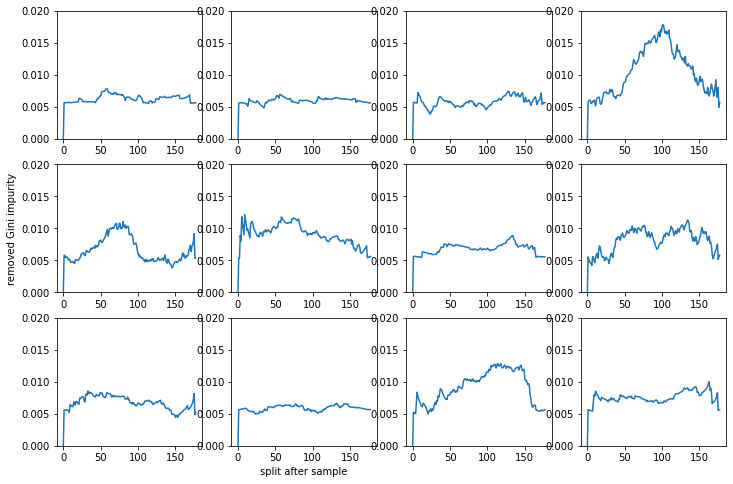

In [50]:
fig,axs = plt.subplots(3, 4, figsize=(12,8))
axs[1][0].set_ylabel('removed Gini impurity')
axs[2][1].set_xlabel('split after sample')

for j in range(0,12): 
    liste=[]
    for i in range(0,178):
        liste.append(splitfunction(X[:,j],i))
    if j==0:
        axs[0][0].plot(range(0,178),liste)
        axs[0][0].set_ylim(0,0.02)
    if j==1:
        axs[0][1].plot(range(0,178),liste)
        axs[0][1].set_ylim(0,0.02)
    if j==2:
        axs[0][2].plot(range(0,178),liste)
        axs[0][2].set_ylim(0,0.02)
    if j==3:
        axs[0][3].plot(range(0,178),liste)
        axs[0][3].set_ylim(0,0.02)
    if j==4:
        axs[1][0].plot(range(0,178),liste)
        axs[1][0].set_ylim(0,0.02)
    if j==5:
        axs[1][1].plot(range(0,178),liste)
        axs[1][1].set_ylim(0,0.02)
    if j==6:
        axs[1][2].plot(range(0,178),liste)
        axs[1][2].set_ylim(0,0.02)
    if j==7:
        axs[1][3].plot(range(0,178),liste)
        axs[1][3].set_ylim(0,0.02)
    if j==8:
        axs[2][0].plot(range(0,178),liste)
        axs[2][0].set_ylim(0,0.02)
    if j==9:
        axs[2][1].plot(range(0,178),liste)
        axs[2][1].set_ylim(0,0.02)
    if j==10:
        axs[2][2].plot(range(0,178),liste)
        axs[2][2].set_ylim(0,0.02)
    if j==11:
        axs[2][3].plot(range(0,178),liste)
        axs[2][3].set_ylim(0,0.02)

The optimal split feature is alcalinity_of_ash because it gives the highest removed gini impurity

#### Task 3.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [51]:
X_new=X[:,0:12]
X_list = X_new.tolist()
X_new2=X[:,:]
X_list2 = X_new2.tolist()

In [52]:
#represents features
header2 = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

In [53]:
def unique_vals(rows, col):
    return set([row[col] for row in rows])

In [54]:
def class_counts(rows):
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [55]:
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [56]:
class Question:

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header2[self.column], condition, str(self.value))

In [57]:
def partition(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [58]:
def gini(rows):
    #Calculate the Gini Impurity for a list of rows.
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [59]:
def info_gain(left, right, current_uncertainty):
    #Information Gain. The uncertainty of the starting node, minus the weighted impurity of two child nodes.
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [60]:
current_uncertainty = gini(X_list)
current_uncertainty

0.9893952783739468

In [61]:
def find_best_split(rows):
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [62]:
best_gain, best_question = find_best_split(X_list)
best_question

Is 7 >= 1.09?

The best is to split on the feature "flavanoids"

In [63]:
class Leaf:
    def __init__(self, rows):
        self.predictions = class_counts(rows)
class Node:
    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [64]:
def build_tree(rows):
    gain, question = find_best_split(rows)

    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Node(question, true_branch, false_branch)

In [65]:
def print_tree(node, spacing=""):

    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [66]:
my_tree = build_tree(X_list2)
print_tree(my_tree)

Is 7 >= 2.04?
--> True:
  Is 2 >= 4.31?
  --> True:
    Is 11 >= 0.92?
    --> True:
      Predict {365.0: 1}
    --> False:
      Predict {380.0: 2}
  --> False:
    Is 4 >= 13.2?
    --> True:
      Is 1 >= 14.12?
      --> True:
        Is 9 >= 2.19?
        --> True:
          Predict {1065.0: 2}
        --> False:
          Is 12 >= 2.85?
          --> True:
            Is 12 >= 3.53?
            --> True:
              Is 12 >= 3.58?
              --> True:
                Predict {1290.0: 1}
              --> False:
                Predict {760.0: 1}
            --> False:
              Is 12 >= 3.33?
              --> True:
                Is 12 >= 3.45?
                --> True:
                  Predict {1480.0: 1}
                --> False:
                  Predict {1080.0: 1}
              --> False:
                Is 11 >= 1.05?
                --> True:
                  Is 11 >= 1.08?
                  --> True:
                    Predict {1045.0: 1}
                 

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(criterion='gini',splitter='best',random_state=0)
clf.fit(X_train,t_train)
pred=clf.predict(X_test)
clf.score(X_test,pred)

1.0